In [ ]:
# ============
# Cell 1 - IMPORTS
# ============
import os, sys, json, csv, math
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

import torch
import torch.nn.functional as F
import timm
from timm.data import resolve_model_data_config

# ============
# CONFIG
# ============
CFG = {
    "dataset.type": "chexlocalize",  # or "csv_bboxes", "mask_dir"
    "paths.project_root": Path("..").resolve(),
    "paths.images": Path("..") / "data" / "images",
    "paths.ann": Path("..") / "data" / "ann",
    "paths.results": Path("..") / "results",

    # CheXlocalize specific
    "chex.root": Path("..") / "datasets" / "chexlocalize" / "sample",
    "chex.seg_json": "gt_segmentations_val.json",

    # CSV specific
    "csv.file": "bboxes.csv",

    # Mask-dir specific
    "mask_dir.path": Path("..") / "data" / "ann" / "masks",

    # Model / run
    "model.name": "vit_base_patch16_224",
    "run.max_images": 100,
    "run.save_attn_maps": True,

    # Logging
    "log.verbose": True,
    "show.table": True,
    "transform.no_crop": True,
}

C:\Users\Magesh\anaconda3\envs\vitx\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Cell 2 --- Performance guardrails ---
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
try:
    torch.set_num_threads(1)
except Exception:
    pass

torch.set_grad_enabled(False)
if hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("medium")

print("Threads:", torch.get_num_threads(), "| CUDA available:", torch.cuda.is_available())

Threads: 1 | CUDA available: False


In [ ]:
# Cell 3 - Create model & transform
model = timm.create_model(CFG["model.name"], pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

cfg = resolve_model_data_config(model)
from timm.data.transforms_factory import transforms_imagenet_eval
H_in, W_in = cfg["input_size"][1], cfg["input_size"][2]
transform = transforms_imagenet_eval(
    img_size=(H_in, W_in),
    interpolation=cfg.get("interpolation", "bicubic"),
    mean=cfg.get("mean", (0.485, 0.456, 0.406)),
    std=cfg.get("std", (0.229, 0.224, 0.225)),
    crop_pct=1.0,
)

patch_size = getattr(model.patch_embed, "patch_size", (16, 16))
grid_h = H_in // patch_size[0]
grid_w = W_in // patch_size[1]

print(f"Loaded {CFG['model.name']} | input: {(3, H_in, W_in)} | grid: {grid_h}x{grid_w}")


Loaded vit_base_patch16_224 | input: (3, 224, 224) | grid: 14x14


In [ ]:
# Cell 4 -
def ensure_dirs():
    res = CFG["paths.results"]
    (res / "metrics").mkdir(parents=True, exist_ok=True)
    (res / "attn_maps").mkdir(parents=True, exist_ok=True)
    (res / "attn_overlays").mkdir(parents=True, exist_ok=True)

def try_decode_rle(rle: Dict) -> np.ndarray:
    from pycocotools import mask as maskUtils
    m = maskUtils.decode(rle)
    if m.ndim == 3:
        m = m[..., 0]
    return m.astype(np.uint8)

def normalize_heatmap(t: torch.Tensor) -> np.ndarray:
    up = t[0, 0].detach().cpu().numpy()
    return (up - up.min()) / (up.max() + 1e-8)

def pointing_game_hit(attn_map_imgspace: np.ndarray, bboxes: List[List[float]]) -> int:
    idx = int(np.argmax(attn_map_imgspace))
    H, W = attn_map_imgspace.shape
    r, c = idx // W, idx % W
    for (x, y, w, h) in bboxes:
        if (x <= c <= x + w) and (y <= r <= y + h):
            return 1
    return 0

def iou_with_bboxes(attn_map_imgspace: np.ndarray, bboxes: List[List[float]], thresh: float) -> float:
    binmap = (attn_map_imgspace >= thresh).astype(np.uint8)
    H, W = binmap.shape
    gt = Image.new("L", (W, H), 0)
    dr = ImageDraw.Draw(gt)
    for (x, y, w, h) in bboxes:
        dr.rectangle([x, y, x + w, y + h], fill=1)
    gt = np.array(gt, dtype=np.uint8)
    inter = (binmap & gt).sum()
    union = (binmap | gt).sum()
    return float(inter) / (float(union) + 1e-8)

def iou_with_mask(attn_map_imgspace: np.ndarray, gt_mask: np.ndarray, thresh: float) -> float:
    H, W = attn_map_imgspace.shape
    if gt_mask.shape != (H, W):
        gt_img = Image.fromarray((gt_mask * 255).astype(np.uint8))
        gt_img = gt_img.resize((W, H), Image.NEAREST)
        gt_mask = (np.array(gt_img) > 0).astype(np.uint8)
    binmap = (attn_map_imgspace >= thresh).astype(np.uint8)
    inter = (binmap & gt_mask).sum()
    union = (binmap | gt_mask).sum()
    return float(inter) / (float(union) + 1e-8)


In [ ]:
#Cell 5 — Dataset Config Override
CFG["dataset.type"] = "chexlocalize"
CFG["chex.root"]    = Path("..") / "datasets" / "chexlocalize" / "sample"
CFG["chex.seg_json"] = "gt_segmentations_val.json"

seg_path = CFG["chex.root"] / CFG["chex.seg_json"]
print("CheX root set to:", CFG["chex.root"])
print("Seg JSON:", seg_path, "| Exists?", seg_path.exists())
assert seg_path.exists(), f"Not found: {seg_path}"


CheX root set to: ..\datasets\chexlocalize\sample
Seg JSON: ..\datasets\chexlocalize\sample\gt_segmentations_val.json | Exists? True


In [ ]:
#Cell 6 - Data set Readers
class Sample:
    def __init__(self, img_path: Path, img_id: str,
                 bboxes: Optional[List[List[float]]] = None,
                 masks: Optional[Dict[str, np.ndarray]] = None):
        self.img_path = img_path
        self.img_id = img_id
        self.bboxes = bboxes or []
        self.masks = masks or {}

class DatasetReader:
    def __iter__(self):
        raise NotImplementedError

class ChexlocalizeReader(DatasetReader):
    def __init__(self, root: Path, seg_json: str):
        self.root = root
        self.seg_path = root / seg_json
        with open(self.seg_path, "r") as f:
            self.data = json.load(f)

    def _id_to_path(self, img_id: str) -> Path:
        parts = img_id.split("_")
        patient, study, view = parts[0], parts[1], "_".join(parts[2:])
        return self.root / "valid" / patient / study / f"{view}.jpg"

    def __iter__(self):
        for img_id, pathologies in self.data.items():
            img_path = self._id_to_path(img_id)
            if not img_path.exists():
                continue
            masks = {}
            for pathology, rle in pathologies.items():
                try:
                    mask = try_decode_rle(rle)
                    masks[pathology] = mask
                except Exception as e:
                    print(f"[WARN] Failed decode {img_id}/{pathology}: {e}")
            yield Sample(img_path=img_path, img_id=img_id, masks=masks)

class CSVBBoxReader(DatasetReader):
    def __init__(self, img_dir: Path, csv_path: Path):
        self.img_dir = img_dir
        self.csv_path = csv_path

    def __iter__(self):
        with open(self.csv_path) as f:
            reader = csv.DictReader(f)
            headers = [h.lower() for h in reader.fieldnames]

            if "filename" in headers: fname_col = "filename"
            elif "file" in headers: fname_col = "file"
            else: raise ValueError("No filename column in CSV")

            if all(c in headers for c in ["x","y","w","h"]):
                mode = "xywh"
            else:
                mode = "xyxy"

            boxmap = {}
            f.seek(0)
            reader = csv.DictReader(f)
            for row in reader:
                fn = Path(row[fname_col]).name
                if mode=="xywh":
                    x,y,w,h = map(float,[row["x"],row["y"],row["w"],row["h"]])
                else:
                    xmin,ymin,xmax,ymax = map(float,[row["xmin"],row["ymin"],row["xmax"],row["ymax"]])
                    x,y,w,h = xmin,ymin,(xmax-xmin),(ymax-ymin)
                boxmap.setdefault(fn, []).append([x,y,w,h])

            for fn, boxes in boxmap.items():
                img_path = self.img_dir / fn
                if not img_path.exists():
                    continue
                yield Sample(img_path=img_path, img_id=fn, bboxes=boxes)

class MaskDirReader(DatasetReader):
    def __init__(self, img_dir: Path, mask_dir: Path):
        self.img_dir = img_dir
        self.mask_dir = mask_dir

    def __iter__(self):
        for p in sorted(self.img_dir.iterdir()):
            if not p.is_file() or p.suffix.lower() not in {".jpg",".jpeg",".png"}:
                continue
            mask_path = self.mask_dir / (p.stem + ".png")
            if not mask_path.exists():
                continue
            m = Image.open(mask_path).convert("L")
            m = (np.array(m) > 0).astype(np.uint8)
            yield Sample(img_path=p, img_id=p.name, masks={"mask": m})

def make_reader():
    dtype = CFG["dataset.type"]
    if dtype == "chexlocalize":
        return ChexlocalizeReader(CFG["chex.root"], CFG["chex.seg_json"])
    if dtype == "csv_bboxes":
        return CSVBBoxReader(CFG["paths.images"], CFG["paths.ann"] / CFG["csv.file"])
    if dtype == "mask_dir":
        return MaskDirReader(CFG["paths.images"], CFG["mask_dir.path"])
    raise ValueError(f"Unknown dataset.type {dtype}")

In [ ]:
r = make_reader()
n, first = 0, None
for s in r:
    n += 1
    if first is None: first = s
print("Samples:", n, "| First:", None if not first else (first.img_id, first.img_path.exists(), bool(first.masks), bool(first.bboxes)))


Samples: 2 | First: ('patient64541_study1_view1_frontal', True, True, False)


In [ ]:
# Cell 7 - ViT Explainers

class ViTExplainer:
    def __init__(self, model_name: str, device: torch.device):
        self.model = timm.create_model(model_name, pretrained=True).to(device).eval()
        self.cfg = resolve_model_data_config(self.model)
        self.device = device
        self._hooks = []
        self.attn_list: List[torch.Tensor] = []

        crop_pct = 1.0 if CFG.get("transform.no_crop", True) else self.cfg.get("crop_pct", 0.875)
        from timm.data.transforms_factory import transforms_imagenet_eval
        H_in, W_in = self.cfg["input_size"][1], self.cfg["input_size"][2]
        self.tf = transforms_imagenet_eval(
            img_size=(H_in, W_in),
            interpolation=self.cfg.get("interpolation", "bicubic"),
            mean=self.cfg.get("mean", (0.485, 0.456, 0.406)),
            std=self.cfg.get("std", (0.229, 0.224, 0.225)),
            crop_pct=crop_pct,
        )
        ps = getattr(self.model.patch_embed, "patch_size", (16,16))
        self.grid_h = H_in // ps[0]
        self.grid_w = W_in // ps[1]
        self._register_hooks()

    def _register_hooks(self):
        def capture_attn(module, inputs, output):
            x = inputs[0]
            B, N, C = x.shape
            with torch.no_grad():
                qkv = module.qkv(x).reshape(B,N,3,module.num_heads,C//module.num_heads)
                qkv = qkv.permute(2,0,3,1,4)
                q,k = qkv[0],qkv[1]
                attn = (q @ k.transpose(-2,-1)) * module.scale
                attn = attn.softmax(dim=-1)
                self.attn_list.append(attn.cpu())
        for blk in self.model.blocks:
            self._hooks.append(blk.attn.register_forward_hook(capture_attn))

    def preprocess(self, pil_img: Image.Image) -> torch.Tensor:
        return self.tf(pil_img).unsqueeze(0).to(self.device)

    def forward_and_attnmap(self, x: torch.Tensor) -> torch.Tensor:
        self.attn_list.clear()
        _ = self.model(x)
        attn_last = self.attn_list[-1]
        attn_mean = attn_last.mean(1)
        cls_to_all = attn_mean[:,0,:]
        patches = cls_to_all[:,1:]
        amap = patches.reshape(1,1,self.grid_h,self.grid_w)
        up = F.interpolate(amap, size=(self.cfg["input_size"][1], self.cfg["input_size"][2]),
                           mode="bilinear", align_corners=False)
        return up


In [ ]:
# ============
# Cell 8 - BENCHMARK (multi-threshold IoU + overlay path logging)
# ============
def run_benchmark():
    ensure_dirs()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    expl = ViTExplainer(CFG["model.name"], device)
    reader = make_reader()

    records = []
    maxn   = CFG.get("run.max_images", None)
    save_maps = CFG.get("run.save_attn_maps", True)
    out_metrics = CFG["paths.results"] / "metrics" / f"{CFG['model.name']}_attn_metrics.csv"

    # thresholds evaluated per image
    thresholds = [0.3, 0.5, 0.7]

    count = 0
    for sample in reader:
        if (maxn is not None) and (count >= maxn):
            break
        if not sample.img_path.exists():
            continue

        # forward
        img = Image.open(sample.img_path).convert("RGB")
        x = expl.preprocess(img)
        amap_up = expl.forward_and_attnmap(x)   # [1,1,H,W]
        attn_img = normalize_heatmap(amap_up)   # (H,W) in [0,1]

        # compute metrics at all thresholds
        metrics = {}
        if sample.masks:
            for t in thresholds:
                ious = [iou_with_mask(attn_img, m, t) for _, m in sample.masks.items()]
                metrics[f"iou@{t}"] = float(np.mean(ious)) if ious else float("nan")
            hit = float("nan")  # pointing game not defined for masks
        elif sample.bboxes:
            for t in thresholds:
                metrics[f"iou@{t}"] = iou_with_bboxes(attn_img, sample.bboxes, t)
            hit = float(pointing_game_hit(attn_img, sample.bboxes))
        else:
            continue  # no GT

        # safe overlay filename
        safe_id = sample.img_id.replace("/", "-").replace("\\", "-")
        overlay_file = f"{safe_id}_{CFG['model.name']}_overlay.png"
        out_png = CFG["paths.results"] / "attn_overlays" / overlay_file
        out_png.parent.mkdir(parents=True, exist_ok=True)  # ensure folder exists

        # save overlay (background X-ray + heatmap)
        if save_maps:
            try:
                import matplotlib.pyplot as plt
                plt.figure(figsize=(4,4))
                plt.imshow(img.resize(attn_img.shape[::-1]))
                plt.imshow(attn_img, cmap="jet", alpha=0.5)
                plt.axis("off")
                plt.tight_layout()
                plt.savefig(out_png, dpi=150)
                plt.close()
            except Exception as e:
                if CFG.get("log.verbose", True):
                    print(f"[WARN] Failed to save overlay for {sample.img_path}: {e}")

        # record row
        record = {
            "file": str(sample.img_path.name),
            "img_id": sample.img_id,
            "model": CFG["model.name"],
            "hit_top1": hit,
            "overlay_path": str(out_png),
        }
        record.update(metrics)  # adds iou@0.3, iou@0.5, iou@0.7
        records.append(record)

        count += 1

    if not records:
        if CFG.get("log.verbose", True):
            print("No records produced. Check dataset config/paths/GT.")
        return None

    # save CSV
    df = pd.DataFrame.from_records(records)
    out_metrics.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_metrics, index=False)

    if CFG.get("log.verbose", True):
        print(f"Saved metrics: {out_metrics}")
    if CFG.get("show.table", True):
        display(df.head())

    return df



In [ ]:
# Cell 9 - Quick run
print("CFG dataset type:", CFG["dataset.type"])
print("CheX root:", CFG.get("chex.root", None))
print("Images dir:", CFG["paths.images"])
print("Annotations dir:", CFG["paths.ann"])

df = run_benchmark()
print("Returned:", type(df), "len:", len(df) if df is not None else 0)


CFG dataset type: chexlocalize
CheX root: ..\datasets\chexlocalize\sample
Images dir: ..\data\images
Annotations dir: ..\data\ann
Saved metrics: ..\results\metrics\vit_base_patch16_224_attn_metrics.csv


,file,img_id,model,hit_top1,overlay_path,iou@0.3,iou@0.5,iou@0.7
0,view1_frontal.jpg,patient64541_study1_view1_frontal,vit_base_patch16_224,NaN,..\results\attn_overlays\patient64541_study1_v...,0.0,0.0,0.0
1,view1_frontal.jpg,patient64542_study1_view1_frontal,vit_base_patch16_224,NaN,..\results\attn_overlays\patient64542_study1_v...,0.0,0.0,0.0


Returned: <class 'pandas.core.frame.DataFrame'> len: 2


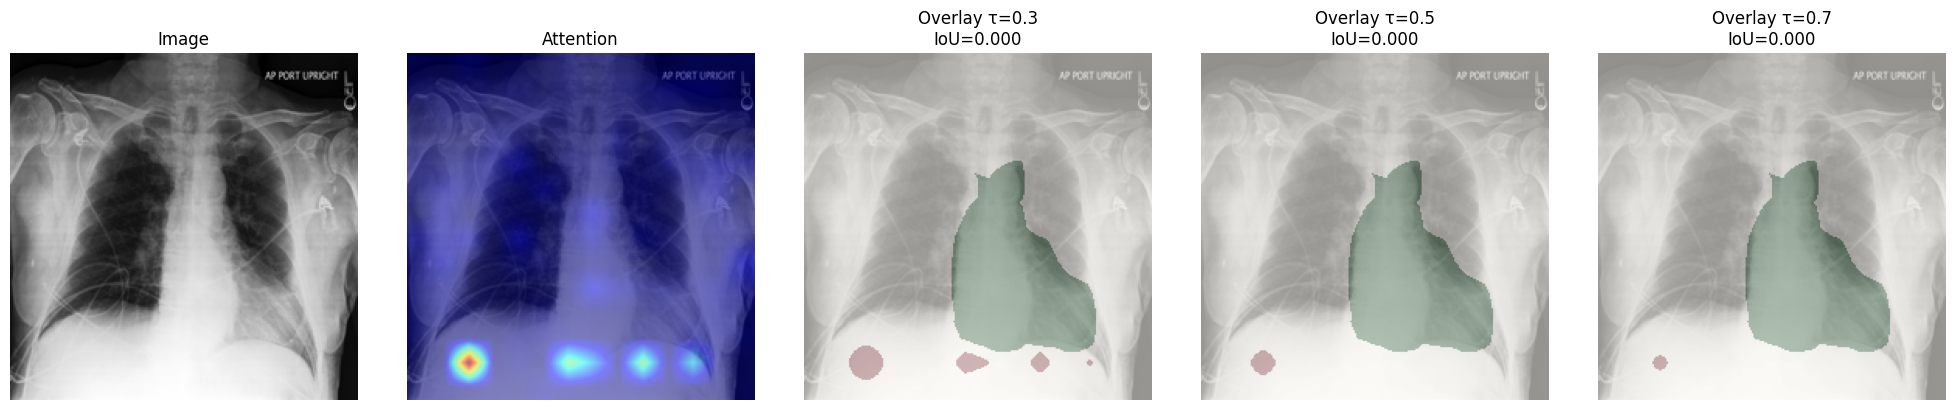

Saved: ..\results\attn_overlays\patient64541_study1_view1_frontal_vit_base_patch16_224_thresholds_bg_iou.png


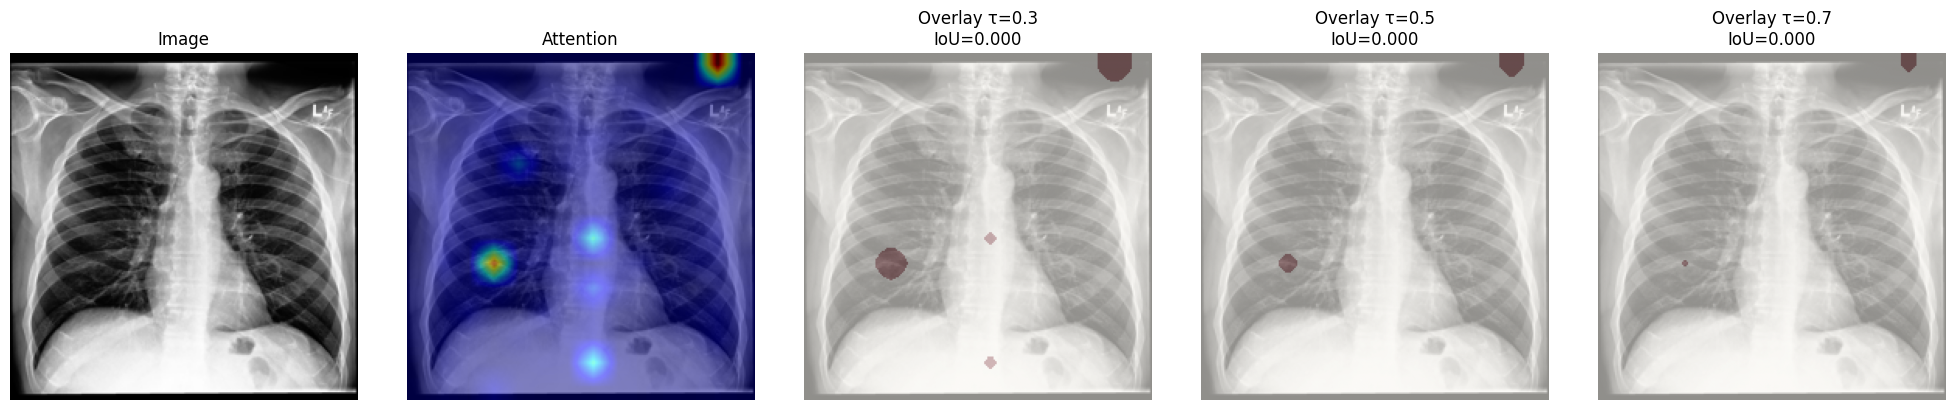

Saved: ..\results\attn_overlays\patient64542_study1_view1_frontal_vit_base_patch16_224_thresholds_bg_iou.png


In [ ]:
# ============
# Cell 10 - VISUALIZATION with background + IoU in titles
# ============
import matplotlib.pyplot as plt

def visualize_thresholds_with_bg(samples_to_show=3, thresholds=[0.3, 0.5, 0.7]):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    expl = ViTExplainer(CFG["model.name"], device)
    reader = make_reader()

    out_dir = CFG["paths.results"] / "attn_overlays"
    out_dir.mkdir(parents=True, exist_ok=True)

    for i, sample in enumerate(reader):
        if i >= samples_to_show:
            break

        img = Image.open(sample.img_path).convert("RGB")
        x = expl.preprocess(img)
        amap = expl.forward_and_attnmap(x)[0,0].cpu().numpy()
        amap = (amap - amap.min())/(amap.max()+1e-8)

        # first mask if available
        if sample.masks:
            name, m = next(iter(sample.masks.items()))
            m_resized = Image.fromarray((m*255).astype("uint8")).resize(amap.shape[::-1], Image.NEAREST)
            m_resized = (np.array(m_resized) > 0).astype(np.uint8)
        else:
            name, m_resized = "no_mask", None

        cols = 2 + len(thresholds)
        plt.figure(figsize=(4*cols, 4))

        # original
        plt.subplot(1, cols, 1)
        plt.imshow(img.resize(amap.shape[::-1])); plt.title("Image"); plt.axis("off")

        # raw attention
        plt.subplot(1, cols, 2)
        plt.imshow(img.resize(amap.shape[::-1]))
        plt.imshow(amap, cmap="jet", alpha=0.5)
        plt.title("Attention"); plt.axis("off")

        # overlays + IoU per threshold
        for j, t in enumerate(thresholds):
            binmap = (amap >= t).astype(np.uint8)
            plt.subplot(1, cols, 3+j)
            plt.imshow(img.resize(amap.shape[::-1]))
            plt.imshow(binmap, cmap="Reds", alpha=0.4)

            iou_val = None
            if m_resized is not None:
                plt.imshow(m_resized, cmap="Greens", alpha=0.3)
                inter = (binmap & m_resized).sum()
                union = (binmap | m_resized).sum()
                iou_val = inter / (union + 1e-8)

            title = f"Overlay τ={t}"
            if iou_val is not None:
                title += f"\nIoU={iou_val:.3f}"
            plt.title(title); plt.axis("off")

        plt.tight_layout()
        # save a multi-threshold panel too
        safe_id = sample.img_id.replace("/", "-").replace("\\", "-")
        save_path = out_dir / f"{safe_id}_{CFG['model.name']}_thresholds_bg_iou.png"
        plt.savefig(save_path, dpi=150)
        plt.show()
        print("Saved:", save_path)
%matplotlib inline
visualize_thresholds_with_bg(samples_to_show=2, thresholds=[0.3, 0.5, 0.7])

In [ ]:
# ============
# Cell 11 = ATTENTION ROLLOUT vs LAST-LAYER (IoU & visuals)
# ============
import matplotlib.pyplot as plt

def attention_rollout(attn_list, add_residual=True):
    """
    attn_list: list of tensors [B, heads, N, N] on CPU, in forward order
    return: rollout matrix [B, N, N]
    """
    mats = [a.mean(1) for a in attn_list]  # [B,N,N]
    outs = []
    for A in mats:
        if add_residual:
            I = torch.eye(A.size(-1)).unsqueeze(0).expand_as(A)
            A = A + I
        A = A / A.sum(-1, keepdim=True)
        outs.append(A)
    R = outs[0]
    for A in outs[1:]:
        R = R @ A
    return R

def compare_rollout_vs_lastlayer(samples_to_show=2, thresh=0.3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    expl = ViTExplainer(CFG["model.name"], device)
    reader = make_reader()

    for i, sample in enumerate(reader):
        if i >= samples_to_show:
            break

        img = Image.open(sample.img_path).convert("RGB")
        x = expl.preprocess(img)

        # last-layer attention map
        amap_last = expl.forward_and_attnmap(x)       # fills expl.attn_list
        last_map = amap_last[0,0].cpu().numpy()
        last_map = (last_map - last_map.min())/(last_map.max()+1e-8)

        # rollout attention map
        R = attention_rollout(expl.attn_list)         # [B,N,N]
        cls_to_all = R[:,0,:]                         # [B,N]
        patches = cls_to_all[:,1:]
        h, w = expl.grid_h, expl.grid_w
        roll_map = patches.reshape(1,1,h,w)
        roll_map = F.interpolate(
            roll_map, size=(expl.cfg["input_size"][1], expl.cfg["input_size"][2]),
            mode="bilinear", align_corners=False
        )[0,0].cpu().numpy()
        roll_map = (roll_map - roll_map.min())/(roll_map.max()+1e-8)

        # IoU against first mask if available
        if sample.masks:
            _, m = next(iter(sample.masks.items()))
            m_resized = Image.fromarray((m*255).astype("uint8")).resize(last_map.shape[::-1], Image.NEAREST)
            gt = (np.array(m_resized) > 0).astype(np.uint8)
            iou_last = ((last_map>=thresh).astype(np.uint8) & gt).sum() / (((last_map>=thresh).astype(np.uint8) | gt).sum() + 1e-8)
            iou_roll = ((roll_map>=thresh).astype(np.uint8) & gt).sum() / (((roll_map>=thresh).astype(np.uint8) | gt).sum() + 1e-8)
        else:
            gt = None
            iou_last = iou_roll = float("nan")

        print(f"{sample.img_id} | IoU(last@{thresh})={iou_last:.3f} | IoU(rollout@{thresh})={iou_roll:.3f}")

        # side-by-side
        plt.figure(figsize=(12,3.5))
        plt.subplot(1,4,1); plt.imshow(img.resize(last_map.shape[::-1])); plt.title("Image"); plt.axis("off")
        plt.subplot(1,4,2); plt.imshow(img.resize(last_map.shape[::-1])); plt.imshow(last_map, cmap="jet", alpha=0.5); plt.title(f"Last-layer"); plt.axis("off")
        plt.subplot(1,4,3); plt.imshow(img.resize(roll_map.shape[::-1])); plt.imshow(roll_map, cmap="jet", alpha=0.5); plt.title("Rollout"); plt.axis("off")
        plt.subplot(1,4,4); plt.imshow(img.resize(last_map.shape[::-1]))
        if gt is not None:
            plt.imshow(gt, cmap="Greens", alpha=0.3)
        plt.imshow(roll_map, cmap="Reds", alpha=0.4)
        plt.title(f"Rollout+GT (τ={thresh})"); plt.axis("off")
        plt.tight_layout(); plt.show()

        compare_rollout_vs_lastlayer(samples_to_show=2, thresh=0.3)


In [ ]:
# ============
# Cell 12 - MULTI-MODEL SWEEP (uses multi-threshold run_benchmark)
# ============
VIT_MODELS = [
    "vit_tiny_patch16_224",
    "vit_small_patch16_224",
    "vit_base_patch16_224",
    "vit_large_patch16_224",
    "deit_small_patch16_224",
    "deit_base_patch16_224",
    "beit_base_patch16_224",
    # "vit_base_patch16_384",  # optional
]

_prev_model = CFG["model.name"]
_prev_max   = CFG.get("run.max_images", None)

# ensure spatial alignment
CFG["transform.no_crop"] = True
# quick pass first (you can raise later)
CFG["run.max_images"] = min(_prev_max, 10) if (_prev_max is not None) else 10

failed = []
for name in VIT_MODELS:
    print(f"\n=== Running: {name} ===")
    CFG["model.name"] = name
    try:
        run_benchmark()
    except Exception as e:
        failed.append((name, repr(e)))
        print("[FAILED]", name, "→", e)

# restore previous settings
CFG["model.name"] = _prev_model
CFG["run.max_images"] = _prev_max
print("\nFailed models:", failed)





=== Running: vit_tiny_patch16_224 ===
Saved metrics: ..\results\metrics\vit_tiny_patch16_224_attn_metrics.csv


,file,img_id,model,hit_top1,overlay_path,iou@0.3,iou@0.5,iou@0.7
0,view1_frontal.jpg,patient64541_study1_view1_frontal,vit_tiny_patch16_224,NaN,..\results\attn_overlays\patient64541_study1_v...,0.0,0.0,0.0
1,view1_frontal.jpg,patient64542_study1_view1_frontal,vit_tiny_patch16_224,NaN,..\results\attn_overlays\patient64542_study1_v...,0.0,0.0,0.0



=== Running: vit_small_patch16_224 ===
Saved metrics: ..\results\metrics\vit_small_patch16_224_attn_metrics.csv


,file,img_id,model,hit_top1,overlay_path,iou@0.3,iou@0.5,iou@0.7
0,view1_frontal.jpg,patient64541_study1_view1_frontal,vit_small_patch16_224,NaN,..\results\attn_overlays\patient64541_study1_v...,0.000105,0.0,0.0
1,view1_frontal.jpg,patient64542_study1_view1_frontal,vit_small_patch16_224,NaN,..\results\attn_overlays\patient64542_study1_v...,0.000000,0.0,0.0



=== Running: vit_base_patch16_224 ===
Saved metrics: ..\results\metrics\vit_base_patch16_224_attn_metrics.csv


,file,img_id,model,hit_top1,overlay_path,iou@0.3,iou@0.5,iou@0.7
0,view1_frontal.jpg,patient64541_study1_view1_frontal,vit_base_patch16_224,NaN,..\results\attn_overlays\patient64541_study1_v...,0.0,0.0,0.0
1,view1_frontal.jpg,patient64542_study1_view1_frontal,vit_base_patch16_224,NaN,..\results\attn_overlays\patient64542_study1_v...,0.0,0.0,0.0



=== Running: vit_large_patch16_224 ===
Saved metrics: ..\results\metrics\vit_large_patch16_224_attn_metrics.csv


,file,img_id,model,hit_top1,overlay_path,iou@0.3,iou@0.5,iou@0.7
0,view1_frontal.jpg,patient64541_study1_view1_frontal,vit_large_patch16_224,NaN,..\results\attn_overlays\patient64541_study1_v...,0.012668,0.002804,0.000452
1,view1_frontal.jpg,patient64542_study1_view1_frontal,vit_large_patch16_224,NaN,..\results\attn_overlays\patient64542_study1_v...,0.003681,0.003612,0.002033



=== Running: deit_small_patch16_224 ===
Saved metrics: ..\results\metrics\deit_small_patch16_224_attn_metrics.csv


,file,img_id,model,hit_top1,overlay_path,iou@0.3,iou@0.5,iou@0.7
0,view1_frontal.jpg,patient64541_study1_view1_frontal,deit_small_patch16_224,NaN,..\results\attn_overlays\patient64541_study1_v...,0.0,0.0,0.0
1,view1_frontal.jpg,patient64542_study1_view1_frontal,deit_small_patch16_224,NaN,..\results\attn_overlays\patient64542_study1_v...,0.0,0.0,0.0



=== Running: deit_base_patch16_224 ===
Saved metrics: ..\results\metrics\deit_base_patch16_224_attn_metrics.csv


,file,img_id,model,hit_top1,overlay_path,iou@0.3,iou@0.5,iou@0.7
0,view1_frontal.jpg,patient64541_study1_view1_frontal,deit_base_patch16_224,NaN,..\results\attn_overlays\patient64541_study1_v...,0.0,0.0,0.0
1,view1_frontal.jpg,patient64542_study1_view1_frontal,deit_base_patch16_224,NaN,..\results\attn_overlays\patient64542_study1_v...,0.0,0.0,0.0



=== Running: beit_base_patch16_224 ===
Saved metrics: ..\results\metrics\beit_base_patch16_224_attn_metrics.csv


,file,img_id,model,hit_top1,overlay_path,iou@0.3,iou@0.5,iou@0.7
0,view1_frontal.jpg,patient64541_study1_view1_frontal,beit_base_patch16_224,NaN,..\results\attn_overlays\patient64541_study1_v...,0.0,0.0,0.0
1,view1_frontal.jpg,patient64542_study1_view1_frontal,beit_base_patch16_224,NaN,..\results\attn_overlays\patient64542_study1_v...,0.0,0.0,0.0



Failed models: []


In [ ]:
# ============
# Cell 13 - AGGREGATE METRICS ACROSS MODELS (multi-threshold aware)
# ============
import pandas as pd, numpy as np
from pathlib import Path

m_dir = CFG["paths.results"] / "metrics"
rows = []

csvs = sorted(m_dir.glob("*_attn_metrics.csv"))
print("Found", len(csvs), "CSV(s) in", m_dir)

for csv_path in csvs:
    df = pd.read_csv(csv_path)
    model = csv_path.stem.replace("_attn_metrics", "")

    # collect IoU columns (e.g., iou@0.3, iou@0.5, iou@0.7)
    iou_cols = [c for c in df.columns if c.startswith("iou@")]

    # means
    mean_iou_all = float(np.nanmean(df[iou_cols].values)) if iou_cols else np.nan
    mean_per_tau = {f"mean_{c}": float(np.nanmean(df[c])) for c in iou_cols}

    # pointing-game (may be NaN for mask datasets)
    if "hit_top1" in df and np.isfinite(df["hit_top1"]).any():
        hit_mean = float(np.nanmean(df["hit_top1"]))
    else:
        hit_mean = np.nan

    rows.append({
        "model": model,
        "n_images": df["img_id"].nunique(),
        **mean_per_tau,
        "Mean_IoU_all": mean_iou_all,
        "Hit@1_mean": hit_mean,
        "csv": str(csv_path),
    })

summary = pd.DataFrame(rows).sort_values("Mean_IoU_all", ascending=False)
out_sum = m_dir / "summary_across_models.csv"
summary.to_csv(out_sum, index=False)

print("Saved summary to:", out_sum)
display(summary)


Found 7 CSV(s) in ..\results\metrics
Saved summary to: ..\results\metrics\summary_across_models.csv


,model,n_images,mean_iou@0.3,mean_iou@0.5,mean_iou@0.7,Mean_IoU_all,Hit@1_mean,csv
4,vit_large_patch16_224,2,0.008174,0.003208,0.001242,0.004208,NaN,..\results\metrics\vit_large_patch16_224_attn_...
5,vit_small_patch16_224,2,0.000052,0.000000,0.000000,0.000017,NaN,..\results\metrics\vit_small_patch16_224_attn_...
0,beit_base_patch16_224,2,0.000000,0.000000,0.000000,0.000000,NaN,..\results\metrics\beit_base_patch16_224_attn_...
2,deit_small_patch16_224,2,0.000000,0.000000,0.000000,0.000000,NaN,..\results\metrics\deit_small_patch16_224_attn...
1,deit_base_patch16_224,2,0.000000,0.000000,0.000000,0.000000,NaN,..\results\metrics\deit_base_patch16_224_attn_...
3,vit_base_patch16_224,2,0.000000,0.000000,0.000000,0.000000,NaN,..\results\metrics\vit_base_patch16_224_attn_m...
6,vit_tiny_patch16_224,2,0.000000,0.000000,0.000000,0.000000,NaN,..\results\metrics\vit_tiny_patch16_224_attn_m...


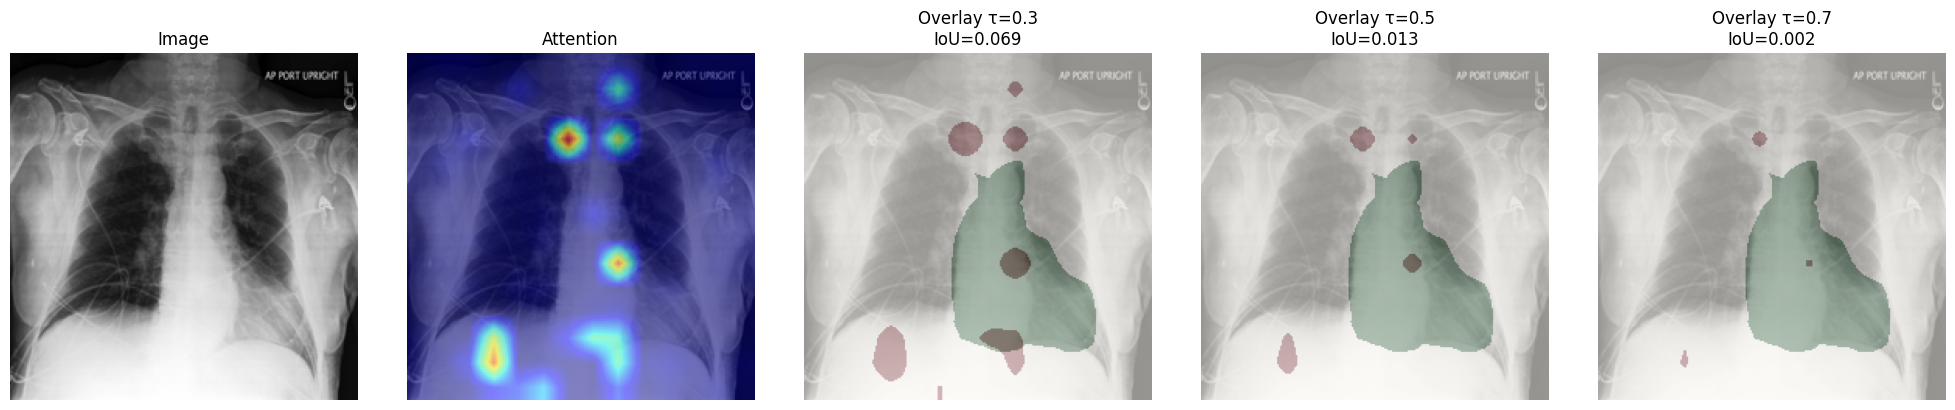

Saved: ..\results\attn_overlays\patient64541_study1_view1_frontal_vit_large_patch16_224_thresholds_bg_iou.png


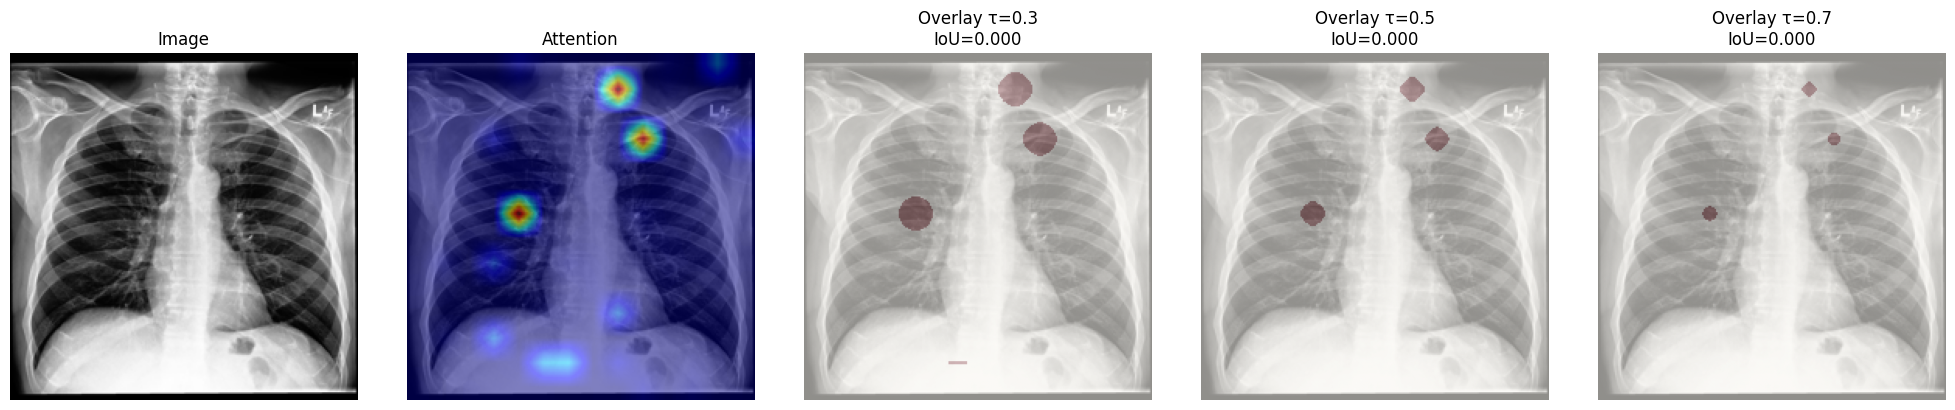

Saved: ..\results\attn_overlays\patient64542_study1_view1_frontal_vit_large_patch16_224_thresholds_bg_iou.png


In [ ]:
best_model = summary.iloc[0]["model"]
CFG["model.name"] = best_model
%matplotlib inline
visualize_thresholds_with_bg(samples_to_show=3, thresholds=[0.3, 0.5, 0.7])  # match Cell 8
